In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
from scipy import stats
import analysis_perDRG
import scikit_posthocs as sp

In [2]:
name = 'd14perDRG_'

with open('D14_SNI_area.json') as f:
    results_sni = json.load(f)
with open('D14_Sham_area.json') as f:
    results_sham = json.load(f)

In [3]:
sham_il = analysis_perDRG.GroupData(results_sham, 'IL', number_of_rats=5)
sham_cl = analysis_perDRG.GroupData(results_sham, 'CL', number_of_rats=5)

sni_il = analysis_perDRG.GroupData(results_sni, 'IL', number_of_rats=6)
sni_cl = analysis_perDRG.GroupData(results_sni, 'CL', number_of_rats=6)

In [4]:
def plot_all(feature, ylabel):
    group_a_data = getattr(sham_il, feature)
    group_b_data = getattr(sham_cl, feature)    
    group_c_data = getattr(sni_il, feature)
    group_d_data = getattr(sni_cl, feature)      
    #statistic(group_a_data, group_b_data)
    
    plt.figure(figsize=(12,8))
    
    labels=['Sham IL', 'Sham CL', 'SNI IL', 'SNI CL']

    c='k'
    alpha=1
    standard_props = {"color":c, "alpha":alpha, "linewidth":5}
    markers= ['D','o']
    line_props = standard_props
    bbox_props = {**standard_props, 'facecolor': 'w', 'edgecolor':c} #dict(edgecolor=c, alpha=alpha, linewidth=5, facecolor='w')
    median_props = standard_props
    cap_props = standard_props
    linewidth = 5
    fontsize = 32
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines['left'].set_linewidth(linewidth)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.tick_params(length=10, width=linewidth)
    if 'tissue area' in ylabel:
        ax.set_ylim([-1, 10.2])
    elif 'Neurons/' in ylabel:
        ax.set_ylim([-1, 400])
    elif 'normalized intensities' in ylabel:
        ax.set_ylim([-0.1, 1.01])
    elif 'intensities' in ylabel:
        ax.set_ylim([-1,4000])
    elif 'GFAP integrated' in ylabel:
        ax.set_ylim([-1,250000000])
    elif 'GS integrated' in ylabel:
        ax.set_ylim([-1,800000000])
    else:
        ax.set_ylim([-1, 101])
    plt.xticks(fontname="Arial", fontsize=fontsize)
    plt.yticks(fontname="Arial", fontsize=fontsize)


    plt.ylabel(ylabel, fontname="Arial", fontsize=34)

    

    sns.boxplot(data=[group_a_data, group_b_data, group_c_data, group_d_data], width=0.5, whiskerprops=line_props, boxprops=bbox_props
                ,capprops=cap_props, medianprops=median_props, fliersize=0)
    sns.stripplot(data=[group_a_data, group_b_data, group_c_data, group_d_data], jitter=0.2, dodge=True, size=8, marker='o', palette='tab20')
    
    ax.set_xticklabels(labels, fontname="Arial", fontsize=34)
    
    plt.savefig('D14 Boxplots/'+name+feature+'.png', bbox_inches = "tight")
    plt.show()

In [5]:
def statistic_all(feature):
    group_a_data = getattr(sham_il, feature)
    group_b_data = getattr(sham_cl, feature)    
    group_c_data = getattr(sni_il, feature)
    group_d_data = getattr(sni_cl, feature)
    
    # Test for normal distribution
    statistic, p_value_a = stats.shapiro(group_a_data)
    statistic, p_value_b = stats.shapiro(group_b_data)
    statistic, p_value_c = stats.shapiro(group_c_data)
    statistic, p_value_d = stats.shapiro(group_d_data)
    
    if (p_value_b < 0.05) or (p_value_a < 0.05) or (p_value_c < 0.05) or (p_value_d < 0.05):
        # data is not normally distrubuted (<0.05)
        # non-parametric version of ANOVA
        statistic, p_value = stats.kruskal(group_a_data, group_b_data, group_c_data, group_d_data, nan_policy='omit')
        print('Mann Whitney U: p-value='+"{:.5f}".format(p_value))
        #perform posthoc mannwhitney-u
        stat = sp.posthoc_mannwhitney([pd.Series(group_a_data).dropna(), pd.Series(group_b_data).dropna(), pd.Series(group_c_data).dropna(), pd.Series(group_d_data).dropna()])
        
    else:
        # data is normally distributed
        # test for equal variance
        statistic, p_value = stats.bartlett(pd.Series(group_a_data).dropna(), pd.Series(group_b_data).dropna(), pd.Series(group_c_data).dropna(), pd.Series(group_d_data).dropna())
        if p_value < 0.05:
            # no equal variance
            equal_variance = False
            # tests the equality of k independent means in the face of heterogeneity of variance
            i = stats.alexandergovern(group_a_data, group_b_data, group_c_data, group_d_data)
            print('Welch’s t-test: p-value='+"{:.5f}".format(111))
 
        else: 
            #data is normally distributed and have equal variances
            equal_variance = True
            statistic, p_value = stats.f_oneway(pd.Series(group_a_data).dropna(), pd.Series(group_b_data).dropna(), pd.Series(group_c_data).dropna(), pd.Series(group_d_data).dropna())
            print('one-way ANOVA: p-value='+"{:.5f}".format(p_value))
        stat = sp.posthoc_ttest([pd.Series(group_a_data).dropna(), pd.Series(group_b_data).dropna(), pd.Series(group_c_data).dropna(), pd.Series(group_d_data).dropna()], equal_var=equal_variance) 
    
    
    stat.columns = ['Sham_IL', 'Sham_CL', 'SNI_IL', 'SNI_CL']
    stat.index = ['Sham_IL', 'Sham_CL', 'SNI_IL', 'SNI_CL']
    return stat.round(4)

In [6]:
def quick_plot(group_a, group_b, feature):
    group_a_data = getattr(group_a, feature)
    group_b_data = getattr(group_b, feature)    
    
    statistic(group_a_data, group_b_data)
    
    plt.figure(figsize=(4,6))
    sns.boxplot(data=[group_a_data, group_b_data])
    sns.stripplot(data=[group_a_data, group_b_data], jitter=0.2)
    ax = plt.gca()
    ax.set_xticklabels([group_a.name, group_b.name], fontsize=16)
    plt.ylabel(feature, fontsize=16)
    plt.show()

In [7]:
def statistic(group_a_data, group_b_data):
    statistic, p_value_a = stats.shapiro(group_a_data)
    statistic, p_value_b = stats.shapiro(group_b_data)
    
    if (p_value_b < 0.05) or (p_value_a < 0.05):
        # data is not normally distrubuted (<0.05)
        statistic, p_value = stats.mannwhitneyu(group_a_data, group_b_data, alternative='two-sided')
        print('Mann Whitney U: p-value='+"{:.5f}".format(p_value))
    else:
        # data is normally distributed
        # test for equal variance
        statistic, p_value = stats.bartlett(group_a_data, group_b_data)
        if p_value < 0.05:
            # no equal variance
            equal_variance = False
            print('Welch-test')
        else: 
            equal_variance = True
            print('t-test')
        # perform t-test
        statistic, p_value = stats.ttest_ind(group_a_data, group_b_data, equal_var=equal_variance, nan_policy='omit')
        print('p-value='+"{:.5f}".format(p_value))

### GFAP rings > 0

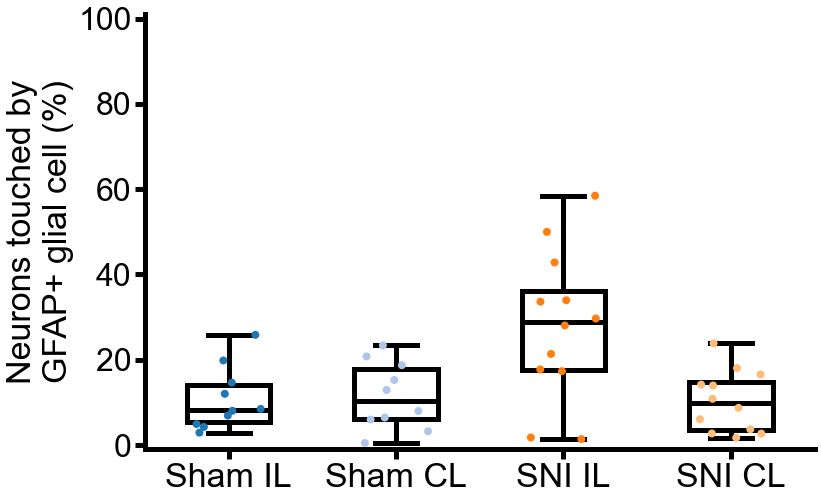

In [8]:
plot_all('ring_ratios_gfap', 'Neurons touched by\nGFAP+ glial cell (%)')

In [9]:
statistic_all('ring_ratios_gfap')

Welch’s t-test: p-value=111.00000


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.8327,0.0072,0.8668
Sham_CL,0.8327,1.0000,0.0098,0.7005
SNI_IL,0.0072,0.0098,1.0000,0.0055
SNI_CL,0.8668,0.7005,0.0055,1.0000


### GS rings > 0

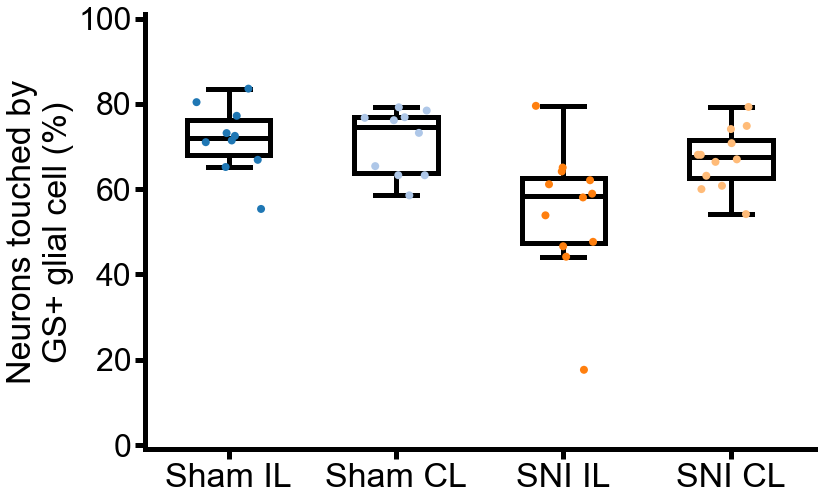

In [10]:
plot_all('ring_ratios_gs', 'Neurons touched by\nGS+ glial cell (%)')

In [11]:
statistic_all('ring_ratios_gs')

Welch’s t-test: p-value=111.00000


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.8751,0.0041,0.1884
Sham_CL,0.8751,1.0000,0.0049,0.2336
SNI_IL,0.0041,0.0049,1.0000,0.0220
SNI_CL,0.1884,0.2336,0.0220,1.0000


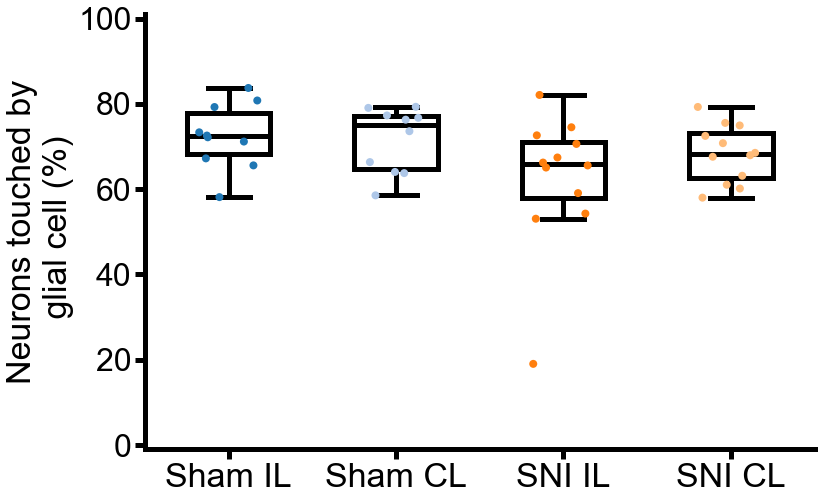

In [12]:
plot_all('ring_ratios_ring', 'Neurons touched by\n glial cell (%)')

In [13]:
statistic_all('ring_ratios_ring')

Mann Whitney U: p-value=0.19027


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.9097,0.0806,0.2485
Sham_CL,0.9097,1.0000,0.1379,0.2485
SNI_IL,0.0806,0.1379,1.0000,0.3123
SNI_CL,0.2485,0.2485,0.3123,1.0000


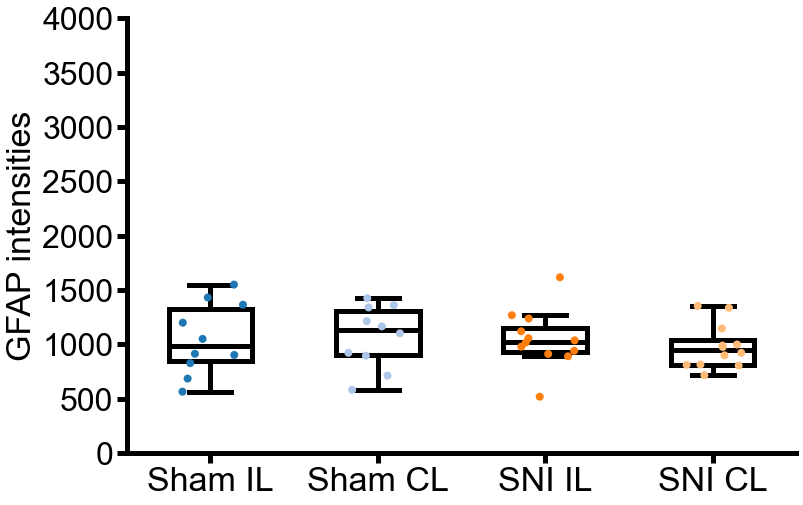

In [14]:
plot_all('gfap_intensities', 'GFAP intensities')

In [15]:
statistic_all('gfap_intensities')

one-way ANOVA: p-value=0.86577


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.8691,0.9964,0.5596
Sham_CL,0.8691,1.0000,0.8494,0.3940
SNI_IL,0.9964,0.8494,1.0000,0.4819
SNI_CL,0.5596,0.3940,0.4819,1.0000


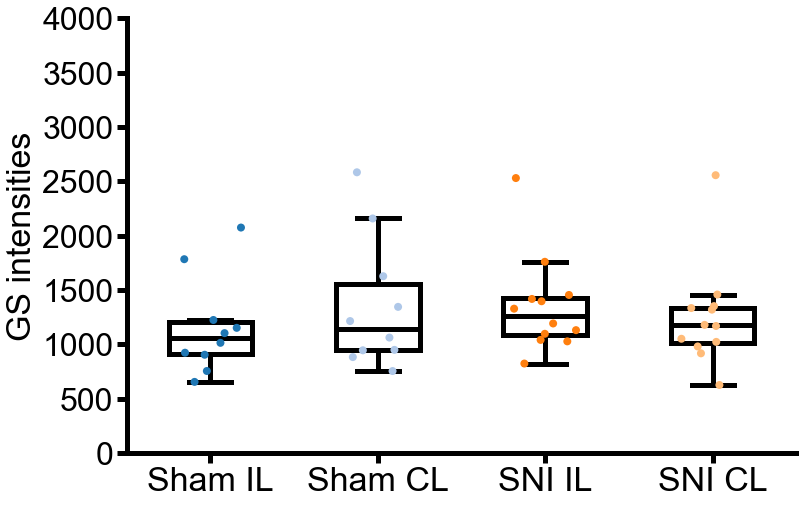

In [16]:
plot_all('gs_intensities', 'GS intensities')

In [17]:
statistic_all('gs_intensities')

Mann Whitney U: p-value=0.57982


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.5205,0.1985,0.4098
Sham_CL,0.5205,1.0000,0.6209,0.9737
SNI_IL,0.1985,0.6209,1.0000,0.4357
SNI_CL,0.4098,0.9737,0.4357,1.0000


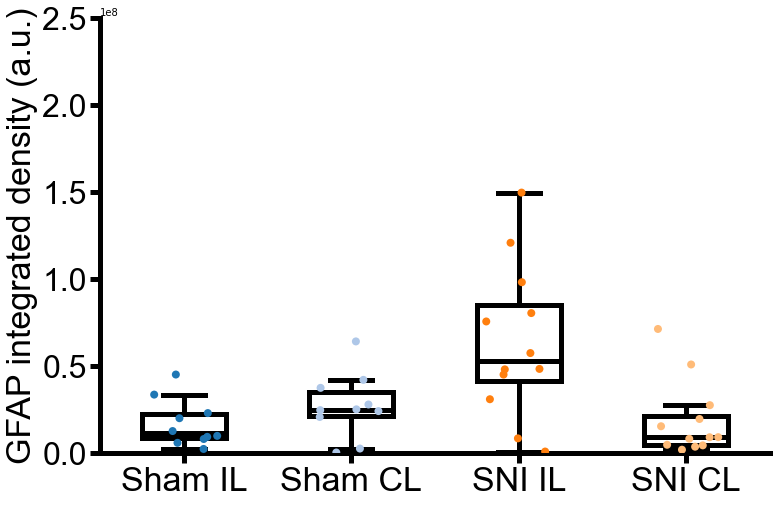

In [18]:
plot_all('gfap_integrated_density', 'GFAP integrated density (a.u.)')

In [19]:
statistic_all('gfap_integrated_density')

Mann Whitney U: p-value=0.01039


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.1859,0.0092,0.6209
Sham_CL,0.1859,1.0000,0.0192,0.2485
SNI_IL,0.0092,0.0192,1.0000,0.0120
SNI_CL,0.6209,0.2485,0.0120,1.0000


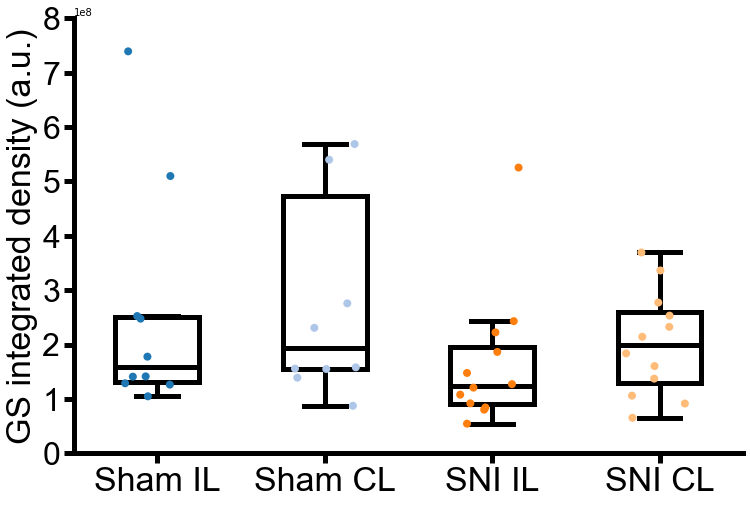

In [20]:
plot_all('gs_integrated_density', 'GS integrated density (a.u.)')

In [21]:
statistic_all('gs_integrated_density')

Mann Whitney U: p-value=0.19359


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.4727,0.1213,0.9737
Sham_CL,0.4727,1.0000,0.0443,0.5752
SNI_IL,0.1213,0.0443,1.0000,0.2145
SNI_CL,0.9737,0.5752,0.2145,1.0000


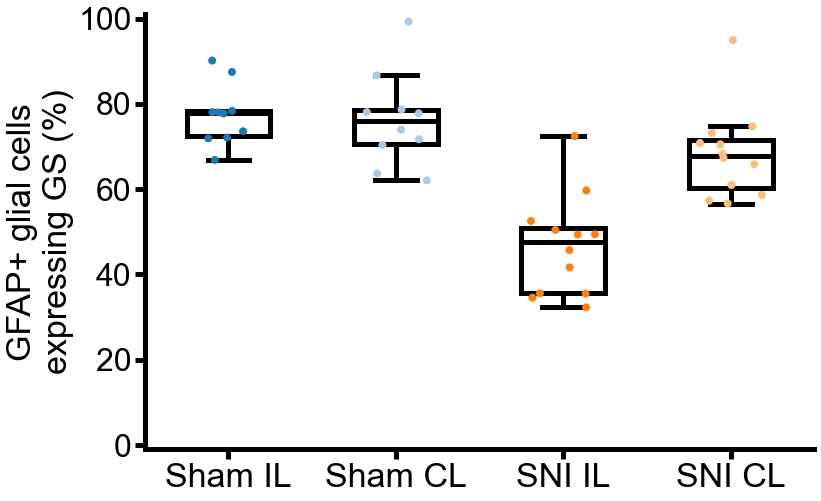

In [22]:
plot_all('gfap_overlaps', 'GFAP+ glial cells\nexpressing GS (%)')

In [23]:
statistic_all('gfap_overlaps')

one-way ANOVA: p-value=0.00000


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.7749,0.0000,0.0288
Sham_CL,0.7749,1.0000,0.0000,0.0962
SNI_IL,0.0000,0.0000,1.0000,0.0001
SNI_CL,0.0288,0.0962,0.0001,1.0000


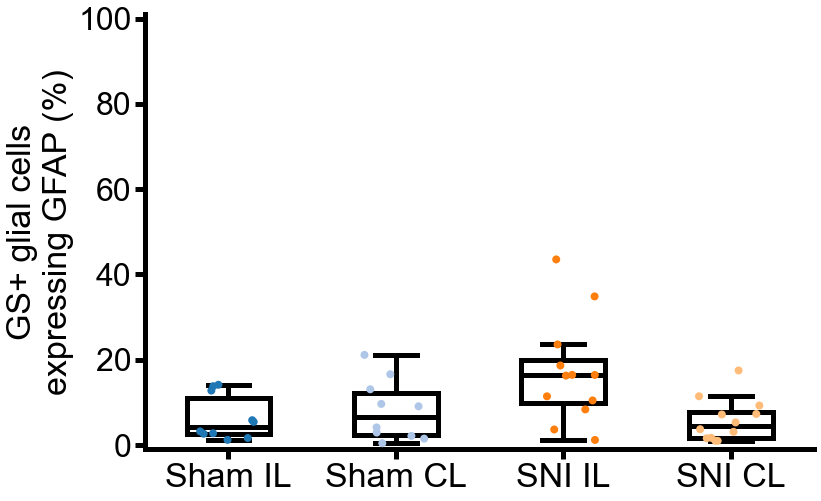

In [24]:
plot_all('gs_overlaps', 'GS+ glial cells\nexpressing GFAP (%)')

In [25]:
statistic_all('gs_overlaps')

Mann Whitney U: p-value=0.03656


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.7913,0.0192,0.7667
Sham_CL,0.7913,1.0000,0.0806,0.5752
SNI_IL,0.0192,0.0806,1.0000,0.0102
SNI_CL,0.7667,0.5752,0.0102,1.0000


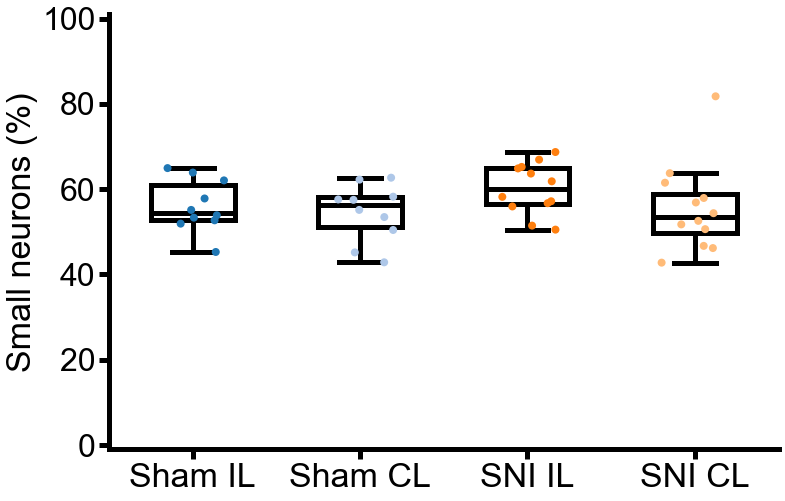

In [26]:
plot_all('small_neurons_percentage', 'Small neurons (%)')

In [27]:
statistic_all('small_neurons_percentage')

one-way ANOVA: p-value=0.32794


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.5918,0.1372,0.8892
Sham_CL,0.5918,1.0000,0.0521,0.7877
SNI_IL,0.1372,0.0521,1.0000,0.2022
SNI_CL,0.8892,0.7877,0.2022,1.0000


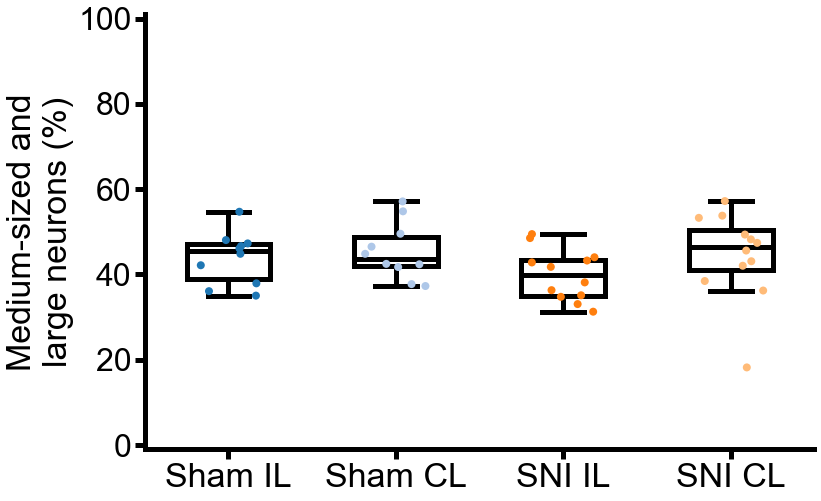

In [28]:
plot_all('bigger_neurons_percentage', 'Medium-sized and\nlarge neurons (%)')

In [29]:
statistic_all('bigger_neurons_percentage')

one-way ANOVA: p-value=0.32794


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.5918,0.1372,0.8892
Sham_CL,0.5918,1.0000,0.0521,0.7877
SNI_IL,0.1372,0.0521,1.0000,0.2022
SNI_CL,0.8892,0.7877,0.2022,1.0000


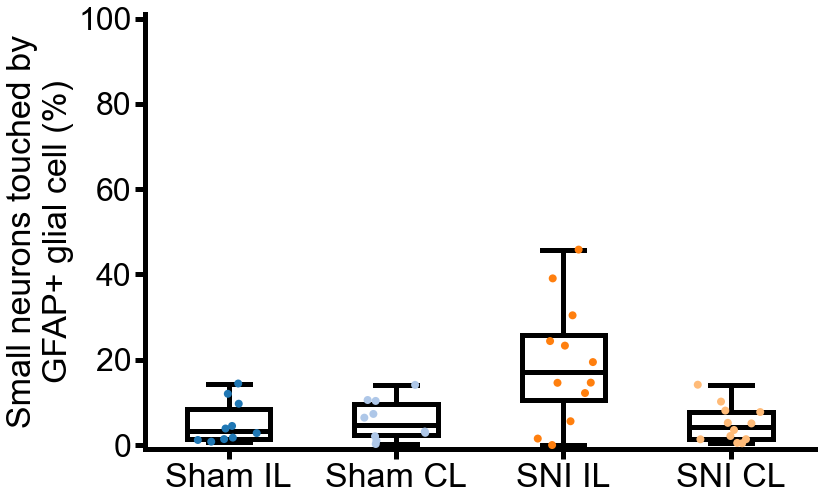

In [30]:
plot_all('small_neurons_gfap_ring', 'Small neurons touched by\nGFAP+ glial cell (%)')

In [31]:
statistic_all('small_neurons_gfap_ring')

Mann Whitney U: p-value=0.01510


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.7913,0.0111,0.9212
Sham_CL,0.7913,1.0000,0.0192,0.7667
SNI_IL,0.0111,0.0192,1.0000,0.0073
SNI_CL,0.9212,0.7667,0.0073,1.0000


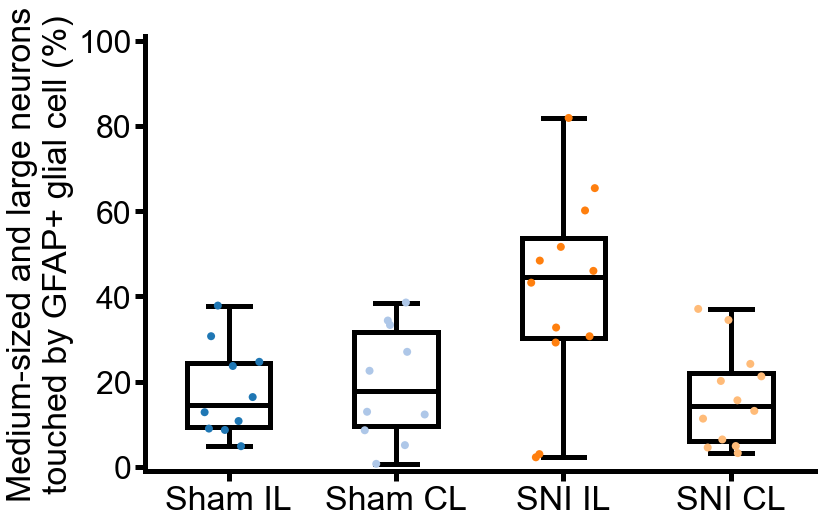

In [32]:
plot_all('bigger_neurons_gfap_ring', 'Medium-sized and large neurons\ntouched by GFAP+ glial cell (%)')

In [33]:
statistic_all('bigger_neurons_gfap_ring')

Welch’s t-test: p-value=111.00000


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.7712,0.0075,0.7441
Sham_CL,0.7712,1.0000,0.0145,0.5608
SNI_IL,0.0075,0.0145,1.0000,0.0046
SNI_CL,0.7441,0.5608,0.0046,1.0000


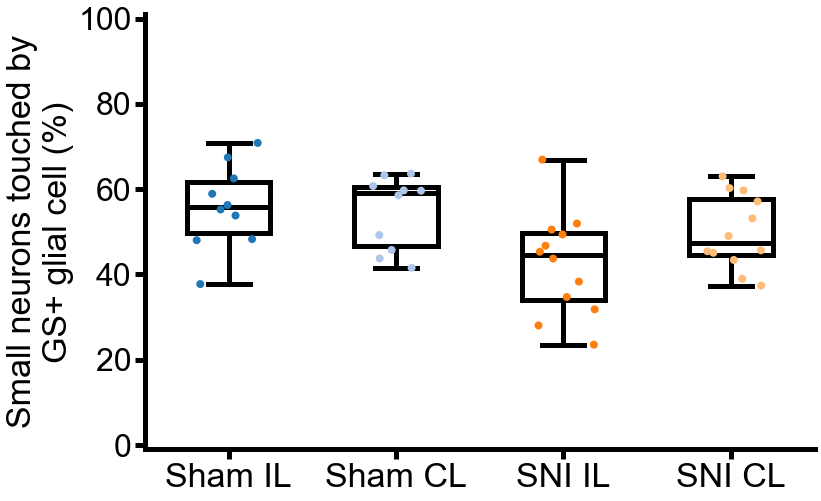

In [34]:
plot_all('small_neurons_gs_ring', 'Small neurons touched by\nGS+ glial cell (%)')

In [35]:
statistic_all('small_neurons_gs_ring')

one-way ANOVA: p-value=0.01215


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.7504,0.0107,0.1384
Sham_CL,0.7504,1.0000,0.0155,0.2127
SNI_IL,0.0107,0.0155,1.0000,0.1026
SNI_CL,0.1384,0.2127,0.1026,1.0000


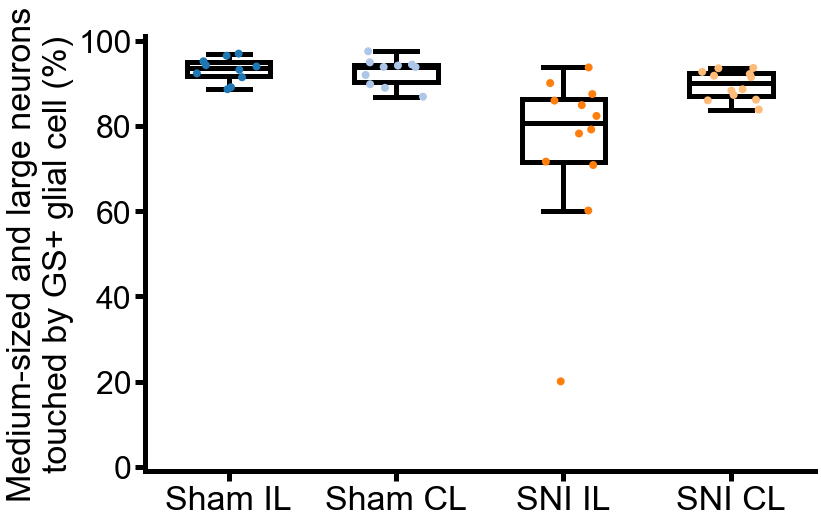

In [36]:
plot_all('bigger_neurons_gs_ring', 'Medium-sized and large neurons\ntouched by GS+ glial cell (%)')

In [37]:
statistic_all('bigger_neurons_gs_ring')

Mann Whitney U: p-value=0.00008


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.7913,0.0005,0.0161
Sham_CL,0.7913,1.0000,0.0007,0.0229
SNI_IL,0.0005,0.0007,1.0000,0.0061
SNI_CL,0.0161,0.0229,0.0061,1.0000


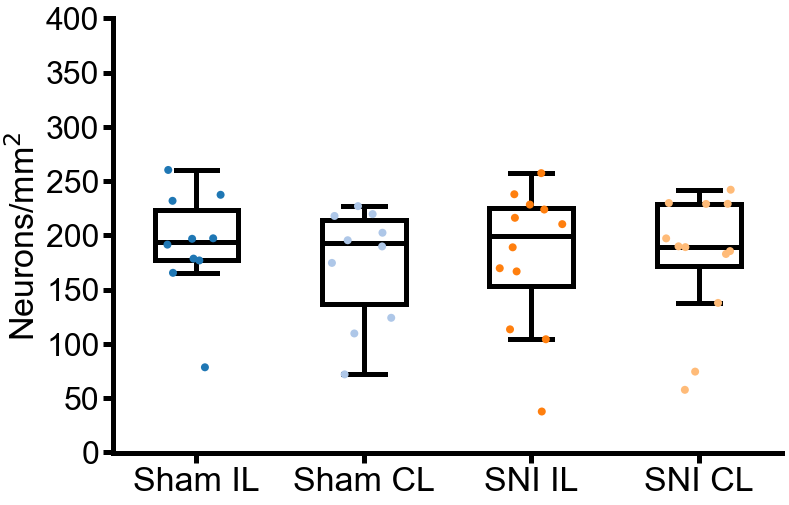

In [38]:
plot_all('neurons_per_tissue', 'Neurons/mm$^2$')

In [39]:
statistic_all('neurons_per_tissue')

Mann Whitney U: p-value=0.91052


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.5205,0.8175,0.6682
Sham_CL,0.5205,1.0000,0.7169,0.6682
SNI_IL,0.8175,0.7169,1.0000,0.9310
SNI_CL,0.6682,0.6682,0.9310,1.0000


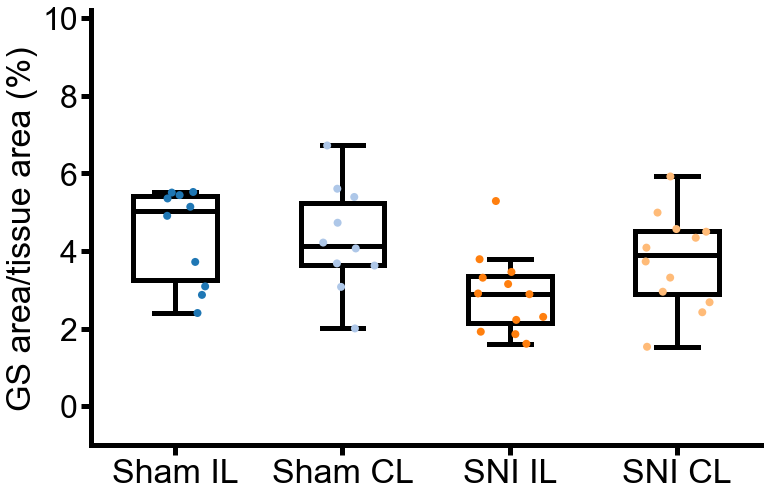

In [40]:
plot_all('gs_area_per_tissue', 'GS area/tissue area (%)')

In [41]:
statistic_all('gs_area_per_tissue')

Mann Whitney U: p-value=0.02653


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.8501,0.0161,0.2485
Sham_CL,0.8501,1.0000,0.0111,0.4483
SNI_IL,0.0161,0.0111,1.0000,0.0783
SNI_CL,0.2485,0.4483,0.0783,1.0000


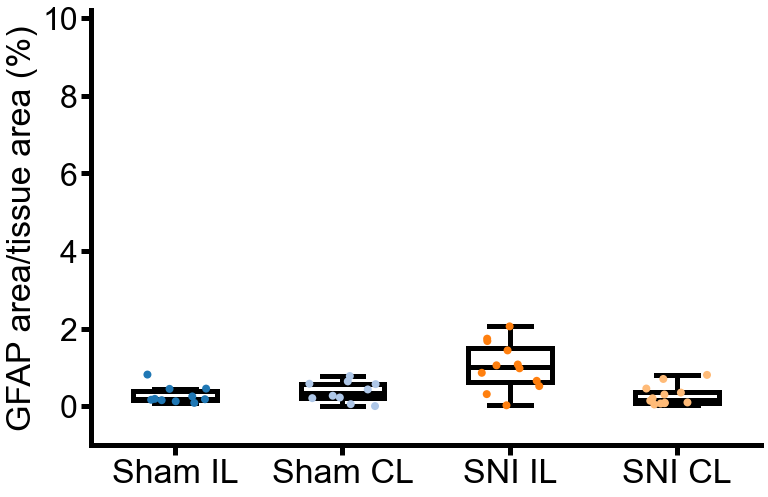

In [42]:
plot_all('gfap_area_per_tissue', 'GFAP area/tissue area (%)')

In [43]:
statistic_all('gfap_area_per_tissue')

Mann Whitney U: p-value=0.00307


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.3847,0.0033,0.5752
Sham_CL,0.3847,1.0000,0.0076,0.4483
SNI_IL,0.0033,0.0076,1.0000,0.0029
SNI_CL,0.5752,0.4483,0.0029,1.0000


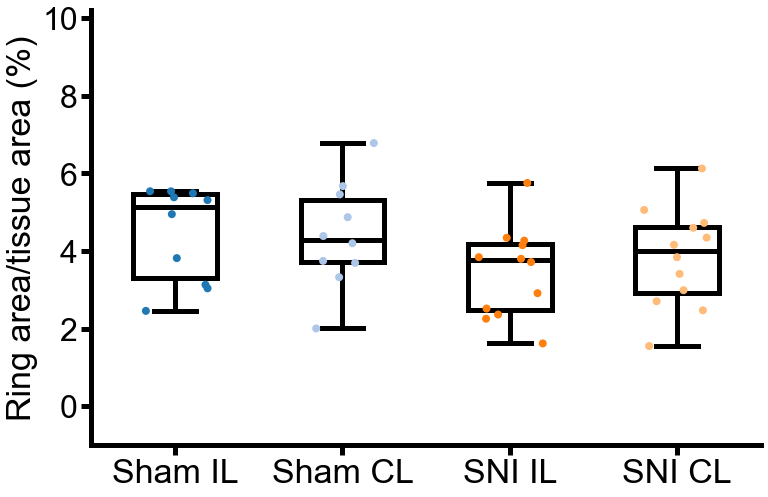

In [44]:
plot_all('ring_area_per_tissue', 'Ring area/tissue area (%)')

In [45]:
statistic_all('ring_area_per_tissue')

Mann Whitney U: p-value=0.23060


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.9097,0.0927,0.2225
Sham_CL,0.9097,1.0000,0.1563,0.3734
SNI_IL,0.0927,0.1563,1.0000,0.3408
SNI_CL,0.2225,0.3734,0.3408,1.0000


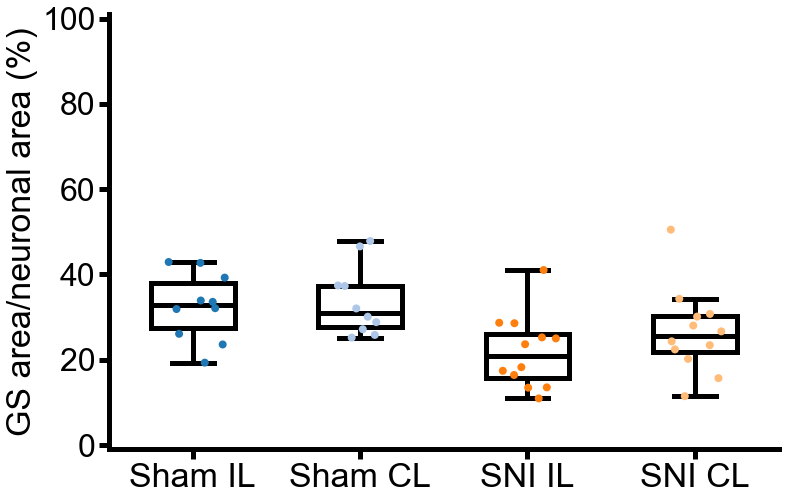

In [46]:
plot_all('gs_area_per_neurons', 'GS area/neuronal area (%)')

In [47]:
statistic_all('gs_area_per_neurons')

one-way ANOVA: p-value=0.00852


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.7240,0.0067,0.1346
Sham_CL,0.7240,1.0000,0.0034,0.0773
SNI_IL,0.0067,0.0034,1.0000,0.2333
SNI_CL,0.1346,0.0773,0.2333,1.0000


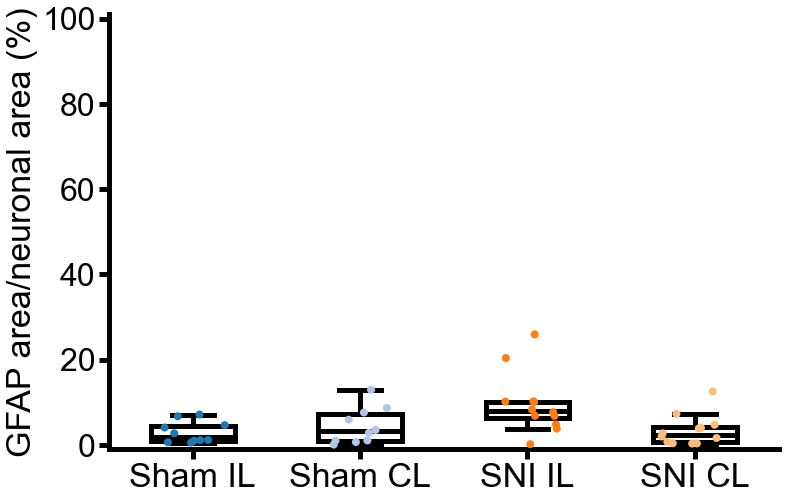

In [48]:
plot_all('gfap_area_per_neurons', 'GFAP area/neuronal area (%)')

In [49]:
statistic_all('gfap_area_per_neurons')

Mann Whitney U: p-value=0.02015


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.5708,0.0062,0.8691
Sham_CL,0.5708,1.0000,0.0518,0.5752
SNI_IL,0.0062,0.0518,1.0000,0.0120
SNI_CL,0.8691,0.5752,0.0120,1.0000


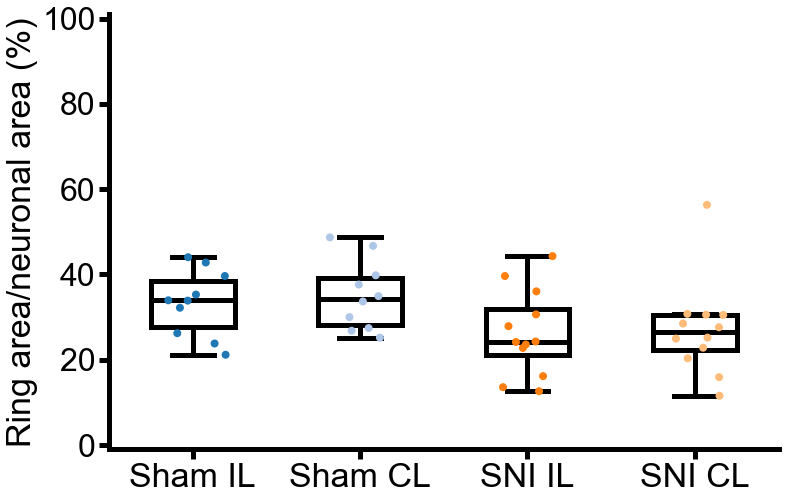

In [50]:
plot_all('ring_area_per_neurons', 'Ring area/neuronal area (%)')

In [51]:
statistic_all('ring_area_per_neurons')

Mann Whitney U: p-value=0.04851


,Sham_IL,Sham_CL,SNI_IL,SNI_CL
Sham_IL,1.0000,0.6776,0.1213,0.0518
Sham_CL,0.6776,1.0000,0.0378,0.0378
SNI_IL,0.1213,0.0378,1.0000,0.8852
SNI_CL,0.0518,0.0378,0.8852,1.0000
